In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
#%cd /content/drive/My-Drive/
# 在線GPU性能检验
!nvidia-smi 
raw = pd.read_csv('/content/gdrive/MyDrive/科技部計畫/data/變數預測股價/DayForDay.csv',index_col=[0])
data = raw["Close"]
data

Mounted at /content/gdrive/
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Date
2017/1/1      1021.750000
2017/1/2      1043.839966
2017/1/3      1154.729980
2017/1/4      1013.380005
2017/1/5       902.200989
                 ...     
2022/8/27    19616.814450
2022/8/28    20297.994140
2022/8/29    19796.808590
2022/8/30    20049.763670
2022/8/31    20126.100000
Name: Close, Length: 2069, dtype: float64

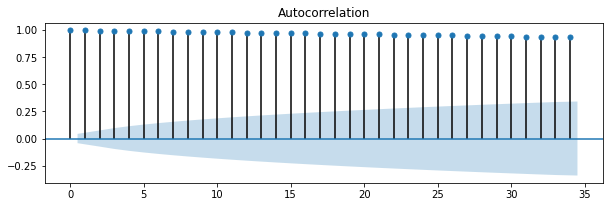

In [ ]:
#ADF檢定-觀察是否定態
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(data, ax=ax1, title="Autocorrelation")
#可以看到自我相關係數相當的明顯，通常這樣的現象會存在序列相關，而序列相關的影響就如同前面所說的會使得變異數隨時間發散，造成古典估計失效。

In [ ]:
#用ADF檢定來看看是否存在單根，虛無假說如下 H0 : D=1
result = adfuller(data)
print('p-value: {}'.format(round(result[1],4)))
#出來結果的P值為0.5199，大於顯著水準，不拒絕虛無假設，也因此我們知道資料為非定態，等等在幫ARIMA定階時要做差分(differencing)處理

p-value: 0.5235


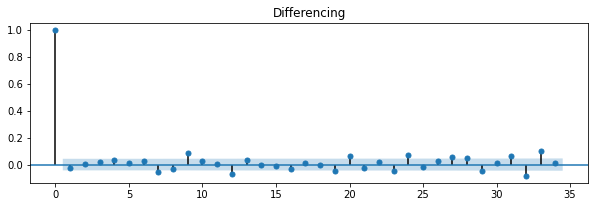

In [ ]:
#差分後的自我相關圖
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(312)
fig = plot_acf(data.diff().dropna(), ax=ax2, title="Differencing")


In [ ]:
result = adfuller(data.diff().dropna())
print('p-value: %f' % result[1])
#自相關看起來變得不顯著

p-value: 0.000000


In [ ]:
#決定落後期數
#在替ARIMA模型定階時有兩個常用的方法，一個直接觀察ACF和PACF圖，另一個則是用訊息準則(Information Criterion)，有三種常見的訊息準則

#1. 赤池資訊準則 (akaike information criterion,AIC )
#2. 赤池資訊準則 (akaike information criterion,AICc)
#3. 貝式資訊準則 (bayesian information criterion,BIC)
#通常在小樣本的時候，會使用AICc，大樣本時使用AIC或BIC，BIC更為強烈，訊息準則越小越好
Order = []
for p in range(1,6):
   for q in range(1,3):
       try:
           model = ARIMA(data, order=(p, 1, q))
           results = model.fit(disp=0)
           Order.append(round(pd.read_html(results.summary().as_html(), header=0, index_col=0)[0].iloc[2,2],2))
       except:
           Order.append('NA')
           print('No Result')
 
b = [Order[i:i+2] for i in range(0,len(Order),2)]
Order_df = pd.DataFrame(b,index=range(1,6),columns=range(1,3))
Order_df.index.name = "p \\ q "
print(tabulate(Order_df, headers='keys', tablefmt='fancy_grid',numalign="center"))

╒══════════╤═════════╤═════════╕
│  p \ q   │    1    │    2    │
╞══════════╪═════════╪═════════╡
│    1     │ 34245.7 │ 34245.7 │
├──────────┼─────────┼─────────┤
│    2     │ 34245.8 │ 34230.4 │
├──────────┼─────────┼─────────┤
│    3     │ 34246.9 │ 34232.2 │
├──────────┼─────────┼─────────┤
│    4     │ 34247.8 │ 34249.8 │
├──────────┼─────────┼─────────┤
│    5     │ 34249.7 │ 34237.6 │
╘══════════╧═════════╧═════════╛


In [ ]:
 #可以觀察到在p=3及q=2時的AIC為最小，故選擇(2,2)作為AR和MA的階數
model = ARIMA(data, order=(4, 1, 2))
results = model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2068
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -17116.902
Method:                       css-mle   S.D. of innovations            951.549
Date:                Wed, 23 Nov 2022   AIC                          34249.804
Time:                        09:22:09   BIC                          34294.878
Sample:                    01-02-2017   HQIC                         34266.326
                         - 08-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.2386     22.043      0.419      0.675     -33.964      52.442
ar.L1.D.Close    -0.0224      0.489     -0.046      0.963      -0.981       0.936
ar.L2.D.Close     0.2168      0.329     

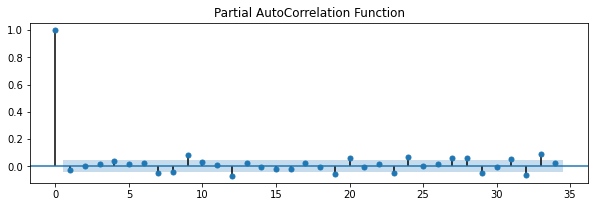

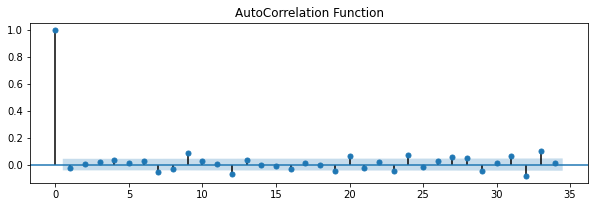

In [ ]:
#PACF,ACF圖，他們分別稱作偏自我相關和自我相關,剛剛提到定階的另一種方法就是觀察這兩張圖
fig = plt.figure(figsize=(10,10))
ax3 = fig.add_subplot(312)
fig = plot_pacf(data.diff().dropna(), ax=ax3, title="Partial AutoCorrelation Function")
fig = plt.figure(figsize=(10,10))
ax4 = fig.add_subplot(312)
fig = plot_acf(data.diff().dropna(), ax=ax4, title="AutoCorrelation Function")

In [ ]:
#估計和執行預測工作
#也就是每天都預測隔一天的結果，而當天結果出來後，我們取來作為訓練資料，接著再預測隔天
price = data.values
length = int(len(price) * 0.2)
train = list(price[0:length])
test =  price[length:len(price)]
date = data.index[length:len(price)]
predictions = []
a = [] 
low_bound = []
up_bound = []
 
for i in range(len(test)):
   model = ARIMA(train, order=(2, 1, 1))
   model_fit = model.fit(disp=0)
   pred = model_fit.forecast()[0]
   predictions.append(pred)
   real = test[i]
   train.append(real)   
   low_bound.append(model_fit.forecast()[2][0][0])
   up_bound.append(model_fit.forecast()[2][0][1])
   
 
   print(date[i] ,"|", 'Pred - '+str(round(pred[0],2)) ,"|", 'Real - '+str(real))
 
MSE = mean_squared_error(test, predictions)
print('Mean Squared Error : '+str(round(MSE,4)))

2018/2/18 | Pred - 10445.36 | Real - 11225.29981
2018/2/19 | Pred - 11329.52 | Real - 11403.7002
2018/2/20 | Pred - 11406.67 | Real - 10690.40039
2018/2/21 | Pred - 10620.49 | Real - 10005.0
2018/2/22 | Pred - 10000.33 | Real - 10301.09961
2018/2/23 | Pred - 10416.74 | Real - 9813.070313
2018/2/24 | Pred - 9785.85 | Real - 9664.730469
2018/2/25 | Pred - 9703.88 | Real - 10366.7002
2018/2/26 | Pred - 10477.4 | Real - 10725.59961
2018/2/27 | Pred - 10740.06 | Real - 10397.90039
2018/2/28 | Pred - 10348.36 | Real - 10951.0
2018/3/1 | Pred - 11086.44 | Real - 11086.40039
2018/3/2 | Pred - 11028.61 | Real - 11489.7002
2018/3/3 | Pred - 11618.26 | Real - 11512.59961
2018/3/4 | Pred - 11505.5 | Real - 11573.29981
2018/3/5 | Pred - 11592.42 | Real - 10779.90039
2018/3/6 | Pred - 10719.86 | Real - 9965.570313
2018/3/7 | Pred - 9957.57 | Real - 9395.009766
2018/3/8 | Pred - 9426.35 | Real - 9337.549805
2018/3/9 | Pred - 9413.65 | Real - 8866.0
2018/3/10 | Pred - 8784.04 | Real - 9578.629883
2018

In [ ]:
import pandas as pd
predict = pd.DataFrame(predictions)
predict
import os
import time
os.chdir('/content/gdrive/MyDrive/科技部計畫/data')
print(os.getcwd() )#获取当前工作路径
timenow= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
type(timenow) #str

outstr= 'ARIMAQuarter0630'+ timenow + '.csv'
predict.to_csv(outstr) #相对位置，保存在getwcd()获得的路径下

outstr